# Image Classification with finetuned GoogleLeNet 

In my previous post [Convolutional neural network for image classification from scratch](http://machinememos.com/python/artificial%20intelligence/machine%20learning/cifar10/neural%20networks/convolutional%20neural%20network/dropout/image%20classification/2017/04/23/convolutional-neural-network-from-scratch.html) I built a small convolutional neural network (CNN) to classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). My goal was to demonstrate how easy one can construct a neural network with descent accuracy (around 67%). However, for many real word problems building CNNs from scratch might not be practical. For instance, in a recent [kaggle](http://kaggle.com/) challenge called [Dog vs Cat](https://www.kaggle.com/c/dogs-vs-cats) the competitors were asked to correctly classify images of dogs and cats. In an insightful [interview](http://blog.kaggle.com/2017/04/03/dogs-vs-cats-redux-playground-competition-winners-interview-bojan-tunguz/) the winner of that challenge explained that he didn't rely solely on a CNN that he built from scratch. Instead he got his hands on multiple models already trained with large datasets and applied some "finetuning" in order to make these fit for the specific goal of classifying cats and dogs. So how does this work? The idea is simple. There are hundreds of models already trained on a specific dataset. The largest repository I know is the [Model Zoo Github Repo](https://github.com/BVLC/caffe/wiki/Model-Zoo). There are also the models from the [Tensorflow Slim Project](https://github.com/tensorflow/models/tree/master/slim). So the goal is to select a model that is already trained on a dataset that is similar to the one you are interested in. After selecting the model one has to apply some "finetuning" on it. Interested? Well continue reading, as this is exactly what I am going to do in this post.  

# Cifar-10 Image Dataset

If you are already familiar with my previous post [Convolutional neural network for image classification from scratch](http://machinememos.com/python/artificial%20intelligence/machine%20learning/cifar10/neural%20networks/convolutional%20neural%20network/dropout/image%20classification/2017/04/23/convolutional-neural-network-from-scratch.html), you might want to skip the next sections and go directly to **Converting datasets to .tfrecord**.

The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60000 32x32 colour images in 10 categories - airplanes, dogs, cats, and other objects. The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. Here are the classes in the dataset, as well as 10 random images from each:
<img src="files/dataset_overview.jpg">
The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks.

## Download the dataset
First, few lines of code will download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [1]:
# DOWNLOAD DATASET 
from urllib.request import urlretrieve
import os
from tqdm import tqdm
import tarfile

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not os.path.isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not os.path.isdir('cifar-10-batches-py'):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()

## Data Overview
The dataset is broken into batches - this is especially useful if one is to train the network on a laptop as it will probably prevent it from running out of memory. I only had 12 GB on mine and a single batch used around 3.2 GB - it wouldn't be possible to load everything at once. Nevertheless, the CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:

* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

Understanding a dataset is part of making predictions on the data. Following functions can be used to view different images by changing the `batch_id` and `sample_id`. The `batch_id` is the id for a batch (1-5). The `sample_id` is the id for a image and label pair in the batch.

In [2]:
import pickle
import matplotlib.pyplot as plt

# The names of the classes in the dataset.
CLASS_NAMES = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

def load_cfar10_batch(batch_id):

    with open(os.path.join('cifar-10-batches-py','data_batch_' 
              + str(batch_id)), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels


def display_stats(features, labels, sample_id):

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'
              .format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch {}:'.format(batch_id))
    print('Samples: {}'.format(len(features)))
    print('Label Counts: {}'.format(dict(zip(*np.unique(labels, return_counts=True)))))
    print('First 20 Labels: {}'.format(labels[:20]))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, CLASS_NAMES[sample_label]))
    plt.axis('off')
    plt.imshow(sample_image)
    plt.show()

Let's check the first couple of images of each batch. The lines below can be easily modified to show an arbitary image from any batch.


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 0:
Image - Min Value: 0 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Label Id: 6 Name: frog


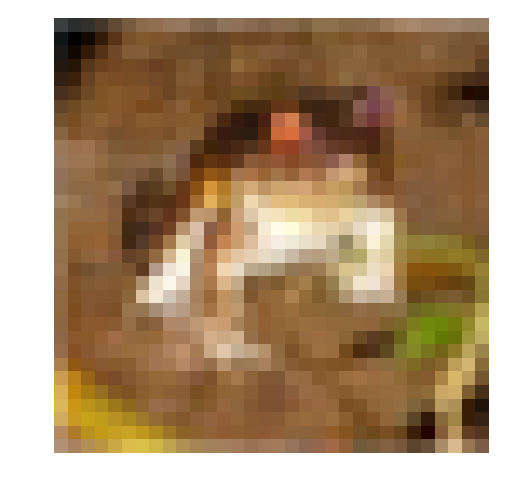


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 1:
Image - Min Value: 5 Max Value: 254
Image - Shape: (32, 32, 3)
Label - Label Id: 9 Name: truck


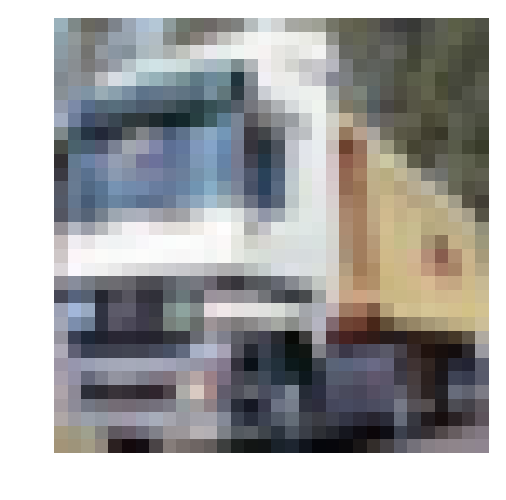


Stats of batch 2:
Samples: 10000
Label Counts: {0: 984, 1: 1007, 2: 1010, 3: 995, 4: 1010, 5: 988, 6: 1008, 7: 1026, 8: 987, 9: 985}
First 20 Labels: [1, 6, 6, 8, 8, 3, 4, 6, 0, 6, 0, 3, 6, 6, 5, 4, 8, 3, 2, 6]

Example of Image 0:
Image - Min Value: 5 Max Value: 225
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


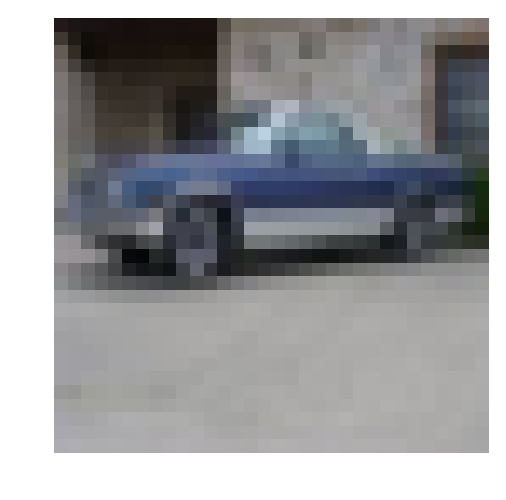


Stats of batch 2:
Samples: 10000
Label Counts: {0: 984, 1: 1007, 2: 1010, 3: 995, 4: 1010, 5: 988, 6: 1008, 7: 1026, 8: 987, 9: 985}
First 20 Labels: [1, 6, 6, 8, 8, 3, 4, 6, 0, 6, 0, 3, 6, 6, 5, 4, 8, 3, 2, 6]

Example of Image 1:
Image - Min Value: 2 Max Value: 247
Image - Shape: (32, 32, 3)
Label - Label Id: 6 Name: frog


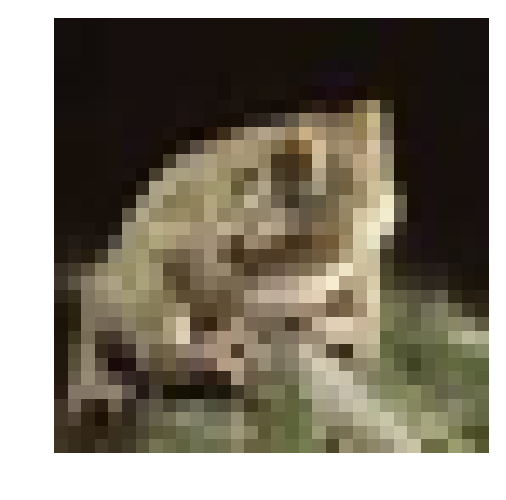


Stats of batch 3:
Samples: 10000
Label Counts: {0: 994, 1: 1042, 2: 965, 3: 997, 4: 990, 5: 1029, 6: 978, 7: 1015, 8: 961, 9: 1029}
First 20 Labels: [8, 5, 0, 6, 9, 2, 8, 3, 6, 2, 7, 4, 6, 9, 0, 0, 7, 3, 7, 2]

Example of Image 0:
Image - Min Value: 0 Max Value: 254
Image - Shape: (32, 32, 3)
Label - Label Id: 8 Name: ship


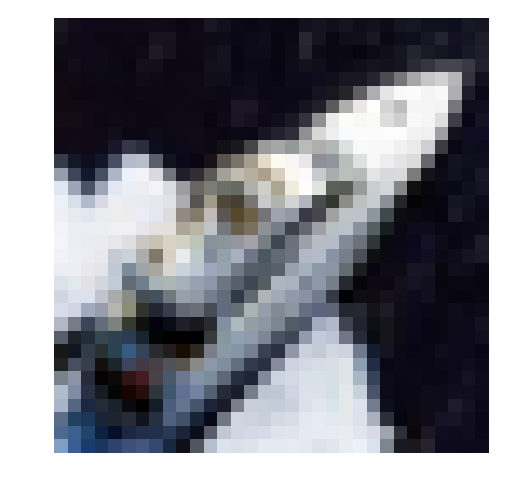


Stats of batch 3:
Samples: 10000
Label Counts: {0: 994, 1: 1042, 2: 965, 3: 997, 4: 990, 5: 1029, 6: 978, 7: 1015, 8: 961, 9: 1029}
First 20 Labels: [8, 5, 0, 6, 9, 2, 8, 3, 6, 2, 7, 4, 6, 9, 0, 0, 7, 3, 7, 2]

Example of Image 1:
Image - Min Value: 15 Max Value: 249
Image - Shape: (32, 32, 3)
Label - Label Id: 5 Name: dog


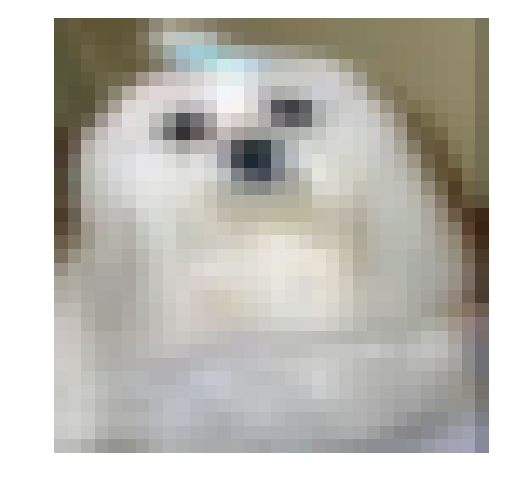


Stats of batch 4:
Samples: 10000
Label Counts: {0: 1003, 1: 963, 2: 1041, 3: 976, 4: 1004, 5: 1021, 6: 1004, 7: 981, 8: 1024, 9: 983}
First 20 Labels: [0, 6, 0, 2, 7, 2, 1, 2, 4, 1, 5, 6, 6, 3, 1, 3, 5, 5, 8, 1]

Example of Image 0:
Image - Min Value: 34 Max Value: 203
Image - Shape: (32, 32, 3)
Label - Label Id: 0 Name: airplane


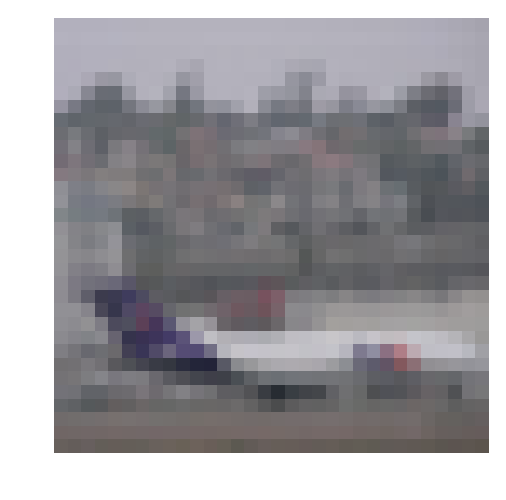


Stats of batch 4:
Samples: 10000
Label Counts: {0: 1003, 1: 963, 2: 1041, 3: 976, 4: 1004, 5: 1021, 6: 1004, 7: 981, 8: 1024, 9: 983}
First 20 Labels: [0, 6, 0, 2, 7, 2, 1, 2, 4, 1, 5, 6, 6, 3, 1, 3, 5, 5, 8, 1]

Example of Image 1:
Image - Min Value: 0 Max Value: 246
Image - Shape: (32, 32, 3)
Label - Label Id: 6 Name: frog


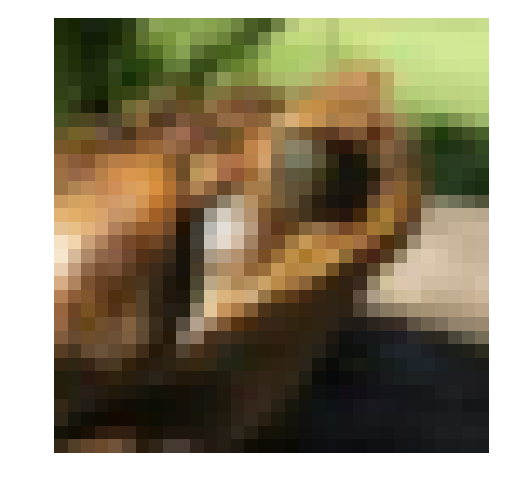


Stats of batch 5:
Samples: 10000
Label Counts: {0: 1014, 1: 1014, 2: 952, 3: 1016, 4: 997, 5: 1025, 6: 980, 7: 977, 8: 1003, 9: 1022}
First 20 Labels: [1, 8, 5, 1, 5, 7, 4, 3, 8, 2, 7, 2, 0, 1, 5, 9, 6, 2, 0, 8]

Example of Image 0:
Image - Min Value: 2 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


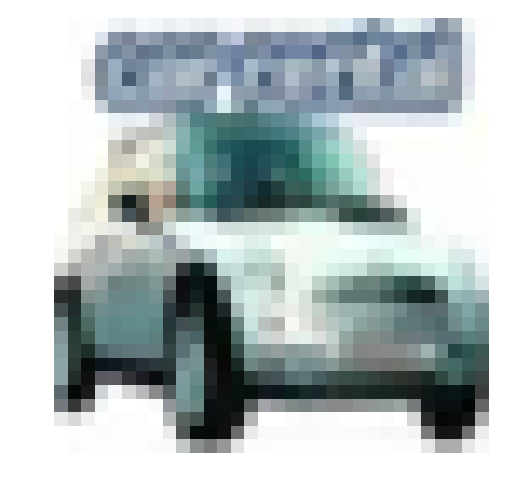


Stats of batch 5:
Samples: 10000
Label Counts: {0: 1014, 1: 1014, 2: 952, 3: 1016, 4: 997, 5: 1025, 6: 980, 7: 977, 8: 1003, 9: 1022}
First 20 Labels: [1, 8, 5, 1, 5, 7, 4, 3, 8, 2, 7, 2, 0, 1, 5, 9, 6, 2, 0, 8]

Example of Image 1:
Image - Min Value: 1 Max Value: 244
Image - Shape: (32, 32, 3)
Label - Label Id: 8 Name: ship


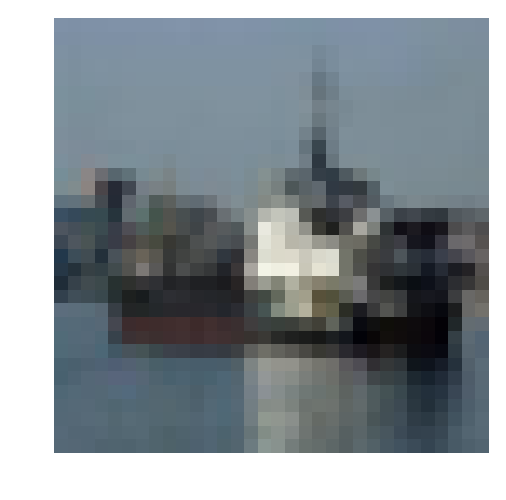

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

for batch_id in range(1,6):
    features, labels = load_cfar10_batch(batch_id)
    for image_id in range(0,2):
        display_stats(features, labels, image_id)

del features, labels # free memory  

# Converting datasets to .tfrecord
Next we convert the datasets to tfrecords. This would allow for the easier further processing by Tensorflow. While the neural network constructed in [Convolutional neural network for image classification from scratch](http://machinememos.com/python/artificial%20intelligence/machine%20learning/cifar10/neural%20networks/convolutional%20neural%20network/dropout/image%20classification/2017/04/23/convolutional-neural-network-from-scratch.html) expected images with size 32x32, the CNN we are going to use here expects an input size of 299x299. Nevertheless, it is not necessary to convert all 60000 images to the target size of 299x299 as this would requre much more of your disk space. Converting the data to tfrecord would actually shrink the dataset size (lossless compression) and allow for the use of tensorflow's preprocessing pipeline and a dynamic conversion to the desired target size of 299x299 at training time.

In [4]:
import sys
import dataset_utils
import tensorflow as tf

IMAGE_SIZE = 32
RGB_CHANNELS = 3

def add_to_tfrecord(filename, tfrecord_writer, offset=0):
    
    with open(filename, mode='rb') as f:
        data = pickle.load(f, encoding='latin1')
    
    images = data['data']
    num_images = images.shape[0]

    images = images.reshape((num_images, RGB_CHANNELS, IMAGE_SIZE, IMAGE_SIZE))
    labels = data['labels']

    with tf.Graph().as_default():
        image_placeholder = tf.placeholder(dtype=tf.uint8)
        encoded_image = tf.image.encode_png(image_placeholder)

        with tf.Session('') as sess:

            for j in range(num_images):
                sys.stdout.write('\r>> Reading file [%s] image %d/%d' % \
                    (filename, offset + j + 1, offset + num_images))
                sys.stdout.flush()

                image = np.squeeze(images[j]).transpose((1, 2, 0))
                label = labels[j]

                png_string = sess.run(encoded_image,\
                         feed_dict={image_placeholder: image})

                example = dataset_utils.image_to_tfexample(\
                    png_string, 'png'.encode('utf-8'), IMAGE_SIZE, IMAGE_SIZE, label)
                tfrecord_writer.write(example.SerializeToString())

    return offset + num_images


if not os.path.isdir('tfrecord'):
    # make the directory
    os.mkdir('tfrecord')
    # write all 5 batches into single training tfrecord
    with tf.python_io.TFRecordWriter(os.path.join('tfrecord', 'cifar-10-training-tfrecord')) as tfrecord_writer:
        offset = 0
        for i in range(1, 6): # Train batches are data_batch_1 ... data_batch_5
            filename = os.path.join('cifar-10-batches-py', 'data_batch_%d' % (i))
            offset = add_to_tfrecord(filename, tfrecord_writer, offset)

    # Next, process the testing data:
    with tf.python_io.TFRecordWriter(os.path.join('tfrecord', 'cifar-10-test-tfrecord')) as tfrecord_writer:
        filename = os.path.join('cifar-10-batches-py', 'test_batch')
        add_to_tfrecord(filename, tfrecord_writer)

    # Finally, write the labels file:
    labels_to_class_names = dict(zip(range(len(CLASS_NAMES)), CLASS_NAMES))

    with tf.gfile.Open(os.path.join('tfrecord', 'labels.txt'), 'w') as f:
        for label in labels_to_class_names:
            class_name = labels_to_class_names[label]
            f.write('%d:%s\n' % (label, class_name))

# Downloading GoogleLeNet
As previously elaborated, selecting a proper network to "finetune" is very important. For this post I chose GoogleLeNet and more specifically the InceptionV3 convolutional neural network. An overview on other fully trained neural networks by Google is available in the [Tensorflow Slim Project](https://github.com/tensorflow/models/tree/master/slim). All four versions of Inception (V1, V2, V3, v4) were trained on part of the [ImageNet](http://www.image-net.org/challenges/LSVRC/2012/) dataset, whick consists of more than 10,000,000 images and over 10,000 categories. The ten categories in Cifar-10 are covered in ImageNet to some extent. Hence, the Inception models should be capable of recognizing images from Cifar-10 after we apply some finetuning. For this post I chose InceptionV3. As a matter of fact, the latest Inception network - InceptionV4 deemed the best results when testet against [ImageNet](http://www.image-net.org/challenges/LSVRC/2012/). However, InceptionV4 is much larger than InceptionV3 und would require much more computational resources when finetuning. Therefore I selected the second best Inception i.e. InceptionV3. The remaining code could be very easily modified to use the other versions of Inception. Given you have time and several GPUs to your dispolsal, I would rather recommend InceptionV4. InceptionV1 is the smallest and very suitable for some proof-of-concept-like projects.

In [5]:
inceptionv3_archive = os.path.join('model', 'inception_v3_2016_08_28.tar.gz')

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not os.path.isdir('model'):
    # create directory to store model
    os.mkdir('model')
    # download the model
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='InceptionV3') as pbar:
        urlretrieve(
            # I hope this url stays there
            'http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz',
            inceptionv3_archive,
            pbar.hook)

    with tarfile.open(inceptionv3_archive) as tar:
        tar.extractall('model')
        tar.close()

### Finetuning InceptionV3
First we define a couple of functions for loading a batch and loading the dataset. 

In [6]:
import inception_preprocessing

def load_batch(dataset, batch_size, height, width, is_training=False):
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32, common_queue_min=8)
    image_raw, label = data_provider.get(['image', 'label'])
    
    # Preprocess image for usage by Inception.
    image = inception_preprocessing.preprocess_image(
        image_raw, height, width, is_training=is_training)
    
    # Preprocess the image for display purposes.
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)

    # Batch it up.
    images, images_raw, labels = tf.train.batch(
          [image, image_raw, label],
          batch_size=batch_size,
          num_threads=1,
          capacity=2 * batch_size)
    
    return images, images_raw, labels

def get_dataset(dataset_file_name, train_sample_size):

    ITEMS_TO_DESCRIPTIONS = {
        'image': 'A [32 x 32 x 3] color image.',
        'label': 'A single integer between 0 and 9',
    }

    keys_to_features = {
          'image/encoded': tf.FixedLenFeature((), tf.string, default_value=''),
          'image/format': tf.FixedLenFeature((), tf.string, default_value='png'),
          'image/class/label': tf.FixedLenFeature(
              [], tf.int64, default_value=tf.zeros([], dtype=tf.int64)),
    }

    items_to_handlers = {
          'image': slim.tfexample_decoder.Image(shape=[IMAGE_SIZE, IMAGE_SIZE, 3]),
          'label': slim.tfexample_decoder.Tensor('image/class/label'),
    }

    labels_to_names = {}
    for i in range(0, len(CLASS_NAMES)):
        labels_to_names[i] = CLASS_NAMES[i]

    decoder = slim.tfexample_decoder.TFExampleDecoder(keys_to_features, items_to_handlers)

    return slim.dataset.Dataset(
          data_sources=dataset_file_name,
          reader=tf.TFRecordReader,
          decoder=decoder,
          num_samples=train_sample_size,
          items_to_descriptions=ITEMS_TO_DESCRIPTIONS,
          num_classes=len(CLASS_NAMES),
          labels_to_names=labels_to_names)

Next we define a function for loading the pretrained model that has been previously downloaded. The function also specifies which variables should be restored from the pretrained model. The actual layers of the neural network are contained in those varaibles. What does finetuning a network means? The process of "finetuning" is selecting layers from the nueral network that should be retrained through backpropagation, while leaving the other layers unchanged. In a neural network for image classification, early layers capture low level details. Each subsequent layer uses the lower level details from its predecessors (e.g. a nose, an eye and a mouth) to caputre a higher level detail (e.g. a dogs or cats face). Take a look at the picture below.
<img src="files/andrewng.jpg">
What Andrew Ng is showing in the [Deep Learning, Self-Taught Learning and Unsupervised Feature Learning](https://www.youtube.com/watch?v=n1ViNeWhC24) is how the level of abstraction is increasing with each subsequent layer of neurons. For more detailed explanation on this matter I can also recommend [Visualizing and Understanding Deep Neural Networks by Matt Zeiler](https://www.youtube.com/watch?v=ghEmQSxT6tw). Anyway, when finetuning you will only train the last few layers of the network. The functions below will not only load the model, but will also create a small log file. The log file [tf_inception_vars.txt](tf_inception variables.txt) shows all tensorflow variables and indicates which variables would remain unchanged and which would be retrained through backpropagation in the process of finetuning.

In [7]:
def get_init_fn():
    """Returns a function run by the chief worker to warm-start the training."""
    checkpoint_exclude_scopes=["InceptionV3/Logits", "InceptionV3/AuxLogits", "InceptionV3/Mixed_7"]
    
    exclusions = [scope.strip() for scope in checkpoint_exclude_scopes]
    
    variables_to_restore = []
    variables_to_retrain = []
    
    for var in slim.get_model_variables():
        excluded = False
        for exclusion in exclusions:
            if var.op.name.startswith(exclusion):
                excluded = True
                break
        if not excluded:
            variables_to_restore.append(var)
        else:
            variables_to_retrain.append(var)
    
    with tf.gfile.Open('tf_inception_vars.txt', 'w') as f:
        for var in variables_to_restore:
             f.write('%s ::RESTORED FROM CHECKPOINT\n' % (var))
        for var in variables_to_retrain:
             f.write('%s ::SELECTED FOR RETRAINING\n' % (var))

    return slim.assign_from_checkpoint_fn(
      os.path.join('model','inception_v3.ckpt'), variables_to_restore)

Finally, we select several hyperparameters. A batch size of 128 pictures was a too much for the 12 GB of RAM I dedicated to my Linux VM. 64 was just fine. A single global step needed around 50 seconds. Hence, 1500 steps is around a day of time. If you have a CUDA-capable NVIDIA GPU the training will be much faster. The learning rate is probably the most importat hyperparameter. If you choose a learning rate too high, your model will converge very fast without actually learning anything. If you choose a learning rate too low, your model will train just fine, but you may not live long enough to see it finally converged. The Adam Optimizer is the least sensitive Optimizer I have tried out. For this tutorial I started with a learning rate of 0.01 and only after 15 steps (10 min of training) I noticed that the loss does not decrease. A learning rate of 0.001 was just fine. I like the AdamOptimizer as it is very tolerant if you chose a learning rate too high. You can also check this [excellent overview on different optimizers](http://sebastianruder.com/optimizing-gradient-descent/index.html#adam). 

In [8]:
from inception_v3 import inception_v3
from inception_v3 import inception_v3_arg_scope

TRAIN_SAMPLES = 50000
INCEPTION_IMAGE_SIZE = 299
BATCH_SIZE = 64
NUMBER_OF_STEPS = 1500
LEARNING_RATE = 0.001

slim = tf.contrib.slim

TRAINED_MODEL_DIR = 'inceptionV3_cifar10_finetuned'

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    train_dataset = get_dataset(
        os.path.join('tfrecord','cifar-10-training-tfrecord'), TRAIN_SAMPLES)
    
    images, _, labels = load_batch(
       train_dataset, BATCH_SIZE, INCEPTION_IMAGE_SIZE, INCEPTION_IMAGE_SIZE)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception_v3_arg_scope()):
        logits, _ = inception_v3(images, num_classes=train_dataset.num_classes, is_training=True)
        
    # Specify the loss function:
    one_hot_labels = slim.one_hot_encoding(labels, train_dataset.num_classes)
    slim.losses.softmax_cross_entropy(logits, one_hot_labels)
    total_loss = slim.losses.get_total_loss()

    # Create some summaries to visualize the training process:
    tf.summary.scalar('losses/Total Loss', total_loss)
  
    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
    train_op = slim.learning.create_train_op(total_loss, optimizer)
    
    # Run the training:
    final_loss = slim.learning.train(
        train_op,
        logdir=TRAINED_MODEL_DIR,
        init_fn=get_init_fn(),
        number_of_steps=NUMBER_OF_STEPS)
        
print('Finished training. Last batch loss %f' % final_loss)

Instructions for updating:
Use tf.losses.softmax_cross_entropy instead.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
Instructions for updating:
Use tf.losses.get_total_loss instead.
Instructions for updating:
Use tf.losses.get_losses instead.
Instructions for updating:
Use tf.losses.get_regularization_losses instead.
INFO:tensorflow:Summary name losses/Total Loss is illegal; using losses/Total_Loss instead.
INFO:tensorflow:Starting Session.
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:global step 1: loss = 2.9792 (76.37 sec/step)
INFO:tensorflow:global step 2: loss = 2.4563 (52.38 sec/step)
INFO:tensorflow:global step 3: loss = 1.8246 (51.16 sec/step)
INFO:tensorflow:global step 4: loss = 1.9932 (51.35 sec/step)
INFO:tensorflow:global step 5: loss = 1.8377 (49.80 sec/step)
INFO:tensorflow:global step 6: loss = 1.7817 (50.04 sec/step)
INFO:tensorflow:global step 7

INFO:tensorflow:global step 92: loss = 1.4313 (50.41 sec/step)
INFO:tensorflow:global step 93: loss = 1.2813 (50.69 sec/step)
INFO:tensorflow:global step 94: loss = 1.3298 (50.36 sec/step)
INFO:tensorflow:global step 95: loss = 1.2124 (50.56 sec/step)
INFO:tensorflow:global step 96: loss = 1.3203 (50.37 sec/step)
INFO:tensorflow:global step 97: loss = 1.3482 (50.53 sec/step)
INFO:tensorflow:global step 98: loss = 1.3757 (50.03 sec/step)
INFO:tensorflow:global step 99: loss = 1.1161 (49.96 sec/step)
INFO:tensorflow:global step 100: loss = 1.0947 (193.74 sec/step)
INFO:tensorflow:global step 101: loss = 1.3144 (53.28 sec/step)
INFO:tensorflow:global step 102: loss = 1.1759 (49.93 sec/step)
INFO:tensorflow:global step 103: loss = 1.0648 (50.19 sec/step)
INFO:tensorflow:global step 104: loss = 1.1484 (50.69 sec/step)
INFO:tensorflow:global step 105: loss = 1.4195 (50.32 sec/step)
INFO:tensorflow:global step 106: loss = 1.1781 (50.82 sec/step)
INFO:tensorflow:global step 107: loss = 1.5032 

INFO:tensorflow:global step 220: loss = 1.0949 (51.25 sec/step)
INFO:tensorflow:global step 221: loss = 1.1630 (51.84 sec/step)
INFO:tensorflow:global step 222: loss = 1.0845 (50.83 sec/step)
INFO:tensorflow:global step 223: loss = 1.5088 (51.40 sec/step)
INFO:tensorflow:global step 224: loss = 1.0180 (120.81 sec/step)
INFO:tensorflow:global step 225: loss = 0.9089 (53.01 sec/step)
INFO:tensorflow:global step 226: loss = 1.4141 (50.88 sec/step)
INFO:tensorflow:global step 227: loss = 1.2149 (51.12 sec/step)
INFO:tensorflow:global step 228: loss = 1.0089 (50.87 sec/step)
INFO:tensorflow:global step 229: loss = 1.1459 (53.06 sec/step)
INFO:tensorflow:global step 230: loss = 1.1048 (51.08 sec/step)
INFO:tensorflow:global step 231: loss = 1.0907 (51.36 sec/step)
INFO:tensorflow:global step 232: loss = 1.1100 (50.75 sec/step)
INFO:tensorflow:global step 233: loss = 1.3446 (51.89 sec/step)
INFO:tensorflow:global step 234: loss = 1.1326 (155.40 sec/step)
INFO:tensorflow:global step 235: loss 

INFO:tensorflow:global step 348: loss = 0.8927 (149.56 sec/step)
INFO:tensorflow:global step 349: loss = 1.0037 (56.44 sec/step)
INFO:tensorflow:global step 350: loss = 1.0331 (63.39 sec/step)
INFO:tensorflow:global step 351: loss = 1.4898 (50.04 sec/step)
INFO:tensorflow:global step 352: loss = 1.3481 (50.32 sec/step)
INFO:tensorflow:global step 353: loss = 1.0747 (49.95 sec/step)
INFO:tensorflow:global step 354: loss = 0.8993 (50.14 sec/step)
INFO:tensorflow:global step 355: loss = 0.8947 (50.35 sec/step)
INFO:tensorflow:global step 356: loss = 0.9508 (50.72 sec/step)
INFO:tensorflow:global step 357: loss = 1.1263 (50.11 sec/step)
INFO:tensorflow:global step 358: loss = 1.3080 (93.63 sec/step)
INFO:tensorflow:global step 359: loss = 0.9935 (52.54 sec/step)
INFO:tensorflow:global step 360: loss = 1.0745 (49.86 sec/step)
INFO:tensorflow:global step 361: loss = 1.0405 (50.06 sec/step)
INFO:tensorflow:global step 362: loss = 0.9745 (50.07 sec/step)
INFO:tensorflow:global step 363: loss =

INFO:tensorflow:global step 476: loss = 0.8775 (50.69 sec/step)
INFO:tensorflow:global step 477: loss = 1.3049 (50.75 sec/step)
INFO:tensorflow:global step 478: loss = 1.0812 (63.12 sec/step)
INFO:tensorflow:global step 479: loss = 0.9856 (78.36 sec/step)
INFO:tensorflow:global step 480: loss = 1.0727 (52.42 sec/step)
INFO:tensorflow:global step 481: loss = 1.1966 (50.58 sec/step)
INFO:tensorflow:global step 482: loss = 1.0015 (50.64 sec/step)
INFO:tensorflow:global step 483: loss = 0.9918 (83.91 sec/step)
INFO:tensorflow:global step 484: loss = 0.9447 (51.70 sec/step)
INFO:tensorflow:global step 485: loss = 0.8496 (51.98 sec/step)
INFO:tensorflow:global step 486: loss = 1.0123 (51.79 sec/step)
INFO:tensorflow:global step 487: loss = 0.8424 (51.03 sec/step)
INFO:tensorflow:global step 488: loss = 1.0511 (51.24 sec/step)
INFO:tensorflow:global step 489: loss = 0.9704 (99.58 sec/step)
INFO:tensorflow:global step 490: loss = 0.7665 (56.05 sec/step)
INFO:tensorflow:global step 491: loss = 

INFO:tensorflow:global step 604: loss = 1.1641 (49.34 sec/step)
INFO:tensorflow:global step 605: loss = 1.0170 (49.46 sec/step)
INFO:tensorflow:global step 606: loss = 0.7003 (57.90 sec/step)
INFO:tensorflow:global step 607: loss = 0.9011 (53.43 sec/step)
INFO:tensorflow:global step 608: loss = 0.9135 (50.66 sec/step)
INFO:tensorflow:global step 609: loss = 1.1207 (49.65 sec/step)
INFO:tensorflow:global step 610: loss = 0.8772 (50.36 sec/step)
INFO:tensorflow:global step 611: loss = 0.9709 (86.93 sec/step)
INFO:tensorflow:global step 612: loss = 0.8891 (51.37 sec/step)
INFO:tensorflow:global step 613: loss = 0.8785 (49.79 sec/step)
INFO:tensorflow:global step 614: loss = 0.9413 (51.54 sec/step)
INFO:tensorflow:global step 615: loss = 1.2117 (49.60 sec/step)
INFO:tensorflow:global step 616: loss = 1.0293 (50.08 sec/step)
INFO:tensorflow:global step 617: loss = 1.0201 (49.88 sec/step)
INFO:tensorflow:global step 618: loss = 0.7942 (50.43 sec/step)
INFO:tensorflow:global step 619: loss = 

INFO:tensorflow:global step 732: loss = 1.0295 (50.00 sec/step)
INFO:tensorflow:global step 733: loss = 0.8185 (50.14 sec/step)
INFO:tensorflow:global step 734: loss = 0.8528 (50.25 sec/step)
INFO:tensorflow:global step 735: loss = 1.0162 (88.34 sec/step)
INFO:tensorflow:global step 736: loss = 0.8734 (51.51 sec/step)
INFO:tensorflow:global step 737: loss = 0.8417 (50.21 sec/step)
INFO:tensorflow:global step 738: loss = 0.9745 (49.84 sec/step)
INFO:tensorflow:global step 739: loss = 1.1195 (49.93 sec/step)
INFO:tensorflow:global step 740: loss = 0.7501 (49.97 sec/step)
INFO:tensorflow:global step 741: loss = 0.8562 (53.46 sec/step)
INFO:tensorflow:global step 742: loss = 0.6169 (53.46 sec/step)
INFO:tensorflow:global step 743: loss = 0.6761 (50.41 sec/step)
INFO:tensorflow:global step 744: loss = 0.9151 (50.84 sec/step)
INFO:tensorflow:global step 745: loss = 0.8467 (49.42 sec/step)
INFO:tensorflow:global step 746: loss = 0.8372 (117.57 sec/step)
INFO:tensorflow:global step 747: loss =

INFO:tensorflow:global step 860: loss = 0.7923 (50.35 sec/step)
INFO:tensorflow:global step 861: loss = 0.9328 (51.38 sec/step)
INFO:tensorflow:global step 862: loss = 0.8758 (51.11 sec/step)
INFO:tensorflow:global step 863: loss = 0.8677 (50.58 sec/step)
INFO:tensorflow:global step 864: loss = 1.1082 (51.93 sec/step)
INFO:tensorflow:global step 865: loss = 0.6588 (50.96 sec/step)
INFO:tensorflow:global step 866: loss = 0.9517 (51.20 sec/step)
INFO:tensorflow:global step 867: loss = 0.7875 (51.71 sec/step)
INFO:tensorflow:global step 868: loss = 0.8056 (51.08 sec/step)
INFO:tensorflow:global step 869: loss = 0.8391 (73.43 sec/step)
INFO:tensorflow:global step 870: loss = 0.6896 (53.34 sec/step)
INFO:tensorflow:global step 871: loss = 1.1308 (50.44 sec/step)
INFO:tensorflow:global step 872: loss = 1.0759 (50.63 sec/step)
INFO:tensorflow:global step 873: loss = 0.7987 (50.72 sec/step)
INFO:tensorflow:global step 874: loss = 0.7279 (50.86 sec/step)
INFO:tensorflow:global step 875: loss = 

INFO:tensorflow:global step 989: loss = 0.8377 (49.69 sec/step)
INFO:tensorflow:global step 990: loss = 0.5889 (50.05 sec/step)
INFO:tensorflow:global step 991: loss = 0.8131 (49.99 sec/step)
INFO:tensorflow:global step 992: loss = 0.6914 (49.89 sec/step)
INFO:tensorflow:global step 993: loss = 0.8321 (49.74 sec/step)
INFO:tensorflow:global step 994: loss = 0.7542 (70.27 sec/step)
INFO:tensorflow:global step 995: loss = 0.7316 (50.53 sec/step)
INFO:tensorflow:global step 996: loss = 0.6549 (49.73 sec/step)
INFO:tensorflow:global step 997: loss = 0.9656 (50.01 sec/step)
INFO:tensorflow:global step 998: loss = 0.9217 (49.53 sec/step)
INFO:tensorflow:global step 999: loss = 0.7944 (49.51 sec/step)
INFO:tensorflow:global step 1000: loss = 0.9367 (49.78 sec/step)
INFO:tensorflow:global step 1001: loss = 0.8512 (49.69 sec/step)
INFO:tensorflow:global step 1002: loss = 0.6207 (50.60 sec/step)
INFO:tensorflow:global step 1003: loss = 0.8173 (50.21 sec/step)
INFO:tensorflow:global step 1004: lo

INFO:tensorflow:global step 1116: loss = 0.6148 (49.78 sec/step)
INFO:tensorflow:global step 1117: loss = 0.5927 (50.39 sec/step)
INFO:tensorflow:global step 1118: loss = 0.5189 (50.16 sec/step)
INFO:tensorflow:global step 1119: loss = 0.7980 (49.85 sec/step)
INFO:tensorflow:global step 1120: loss = 0.8445 (116.10 sec/step)
INFO:tensorflow:global step 1121: loss = 0.8163 (50.77 sec/step)
INFO:tensorflow:global step 1122: loss = 0.6683 (51.57 sec/step)
INFO:tensorflow:global step 1123: loss = 0.7203 (54.90 sec/step)
INFO:tensorflow:global step 1124: loss = 0.8926 (54.27 sec/step)
INFO:tensorflow:global step 1125: loss = 0.8602 (54.85 sec/step)
INFO:tensorflow:global step 1126: loss = 0.7219 (51.57 sec/step)
INFO:tensorflow:global step 1127: loss = 0.6270 (49.56 sec/step)
INFO:tensorflow:global step 1128: loss = 0.8640 (50.13 sec/step)
INFO:tensorflow:global step 1129: loss = 0.7215 (49.41 sec/step)
INFO:tensorflow:global step 1130: loss = 0.6767 (71.23 sec/step)
INFO:tensorflow:global s

INFO:tensorflow:global step 1242: loss = 0.9064 (54.42 sec/step)
INFO:tensorflow:global step 1243: loss = 0.6501 (50.40 sec/step)
INFO:tensorflow:global step 1244: loss = 0.9092 (50.43 sec/step)
INFO:tensorflow:global step 1245: loss = 0.7471 (50.24 sec/step)
INFO:tensorflow:global step 1246: loss = 0.6544 (50.22 sec/step)
INFO:tensorflow:global step 1247: loss = 0.8861 (49.97 sec/step)
INFO:tensorflow:global step 1248: loss = 0.9646 (49.97 sec/step)
INFO:tensorflow:global step 1249: loss = 0.5845 (50.76 sec/step)
INFO:tensorflow:global step 1250: loss = 0.8868 (49.95 sec/step)
INFO:tensorflow:global step 1251: loss = 0.5965 (50.33 sec/step)
INFO:tensorflow:global step 1252: loss = 0.6826 (50.38 sec/step)
INFO:tensorflow:global step 1253: loss = 0.7816 (72.78 sec/step)
INFO:tensorflow:global step 1254: loss = 0.6271 (51.66 sec/step)
INFO:tensorflow:global step 1255: loss = 0.6135 (50.53 sec/step)
INFO:tensorflow:global step 1256: loss = 0.8202 (50.72 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 1368: loss = 0.6294 (53.84 sec/step)
INFO:tensorflow:global step 1369: loss = 0.6369 (52.83 sec/step)
INFO:tensorflow:global step 1370: loss = 0.8318 (56.14 sec/step)
INFO:tensorflow:global step 1371: loss = 0.6192 (51.38 sec/step)
INFO:tensorflow:global step 1372: loss = 0.8165 (51.28 sec/step)
INFO:tensorflow:global step 1373: loss = 0.8227 (51.53 sec/step)
INFO:tensorflow:global step 1374: loss = 0.6240 (51.08 sec/step)
INFO:tensorflow:global step 1375: loss = 0.7241 (95.47 sec/step)
INFO:tensorflow:global step 1376: loss = 0.7301 (58.31 sec/step)
INFO:tensorflow:global step 1377: loss = 0.8183 (51.30 sec/step)
INFO:tensorflow:global step 1378: loss = 0.9132 (50.53 sec/step)
INFO:tensorflow:global step 1379: loss = 0.8326 (51.25 sec/step)
INFO:tensorflow:global step 1380: loss = 0.6918 (51.12 sec/step)
INFO:tensorflow:global step 1381: loss = 0.7035 (51.73 sec/step)
INFO:tensorflow:global step 1382: loss = 0.6364 (51.46 sec/step)
INFO:tensorflow:global st

INFO:tensorflow:global step 1494: loss = 0.5629 (50.39 sec/step)
INFO:tensorflow:global step 1495: loss = 0.7747 (124.66 sec/step)
INFO:tensorflow:global step 1496: loss = 0.5959 (53.37 sec/step)
INFO:tensorflow:global step 1497: loss = 0.6893 (50.19 sec/step)
INFO:tensorflow:global step 1498: loss = 0.5368 (50.39 sec/step)
INFO:tensorflow:global step 1499: loss = 0.8566 (50.85 sec/step)
INFO:tensorflow:global step 1500: loss = 0.6417 (50.32 sec/step)
INFO:tensorflow:Stopping Training.
INFO:tensorflow:Finished training! Saving model to disk.
Finished training. Last batch loss 0.641681


# Evaluation
The neural networks I trained in my last post [Convolutional neural network for image classification from scratch](http://machinememos.com/python/artificial%20intelligence/machine%20learning/cifar10/neural%20networks/convolutional%20neural%20network/dropout/image%20classification/2017/04/23/convolutional-neural-network-from-scratch.html) was classifying 67% of the images correctly. As there are 10 categories, a random guess would classify 10% of the images correctly. Hence, 67% is quite good. Let's see...

Instructions for updating:
Use `tf.local_variables_initializer` instead.


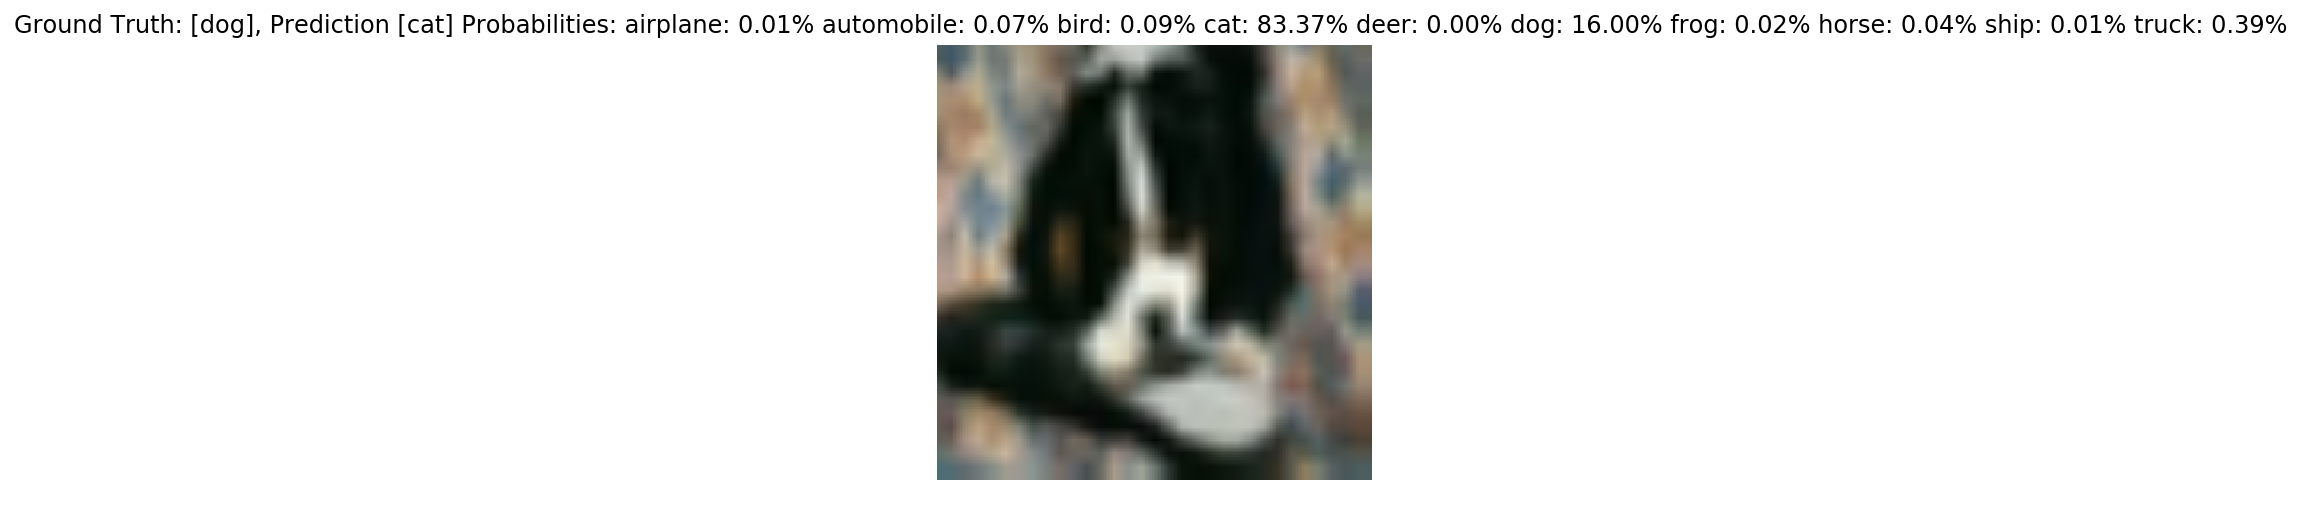

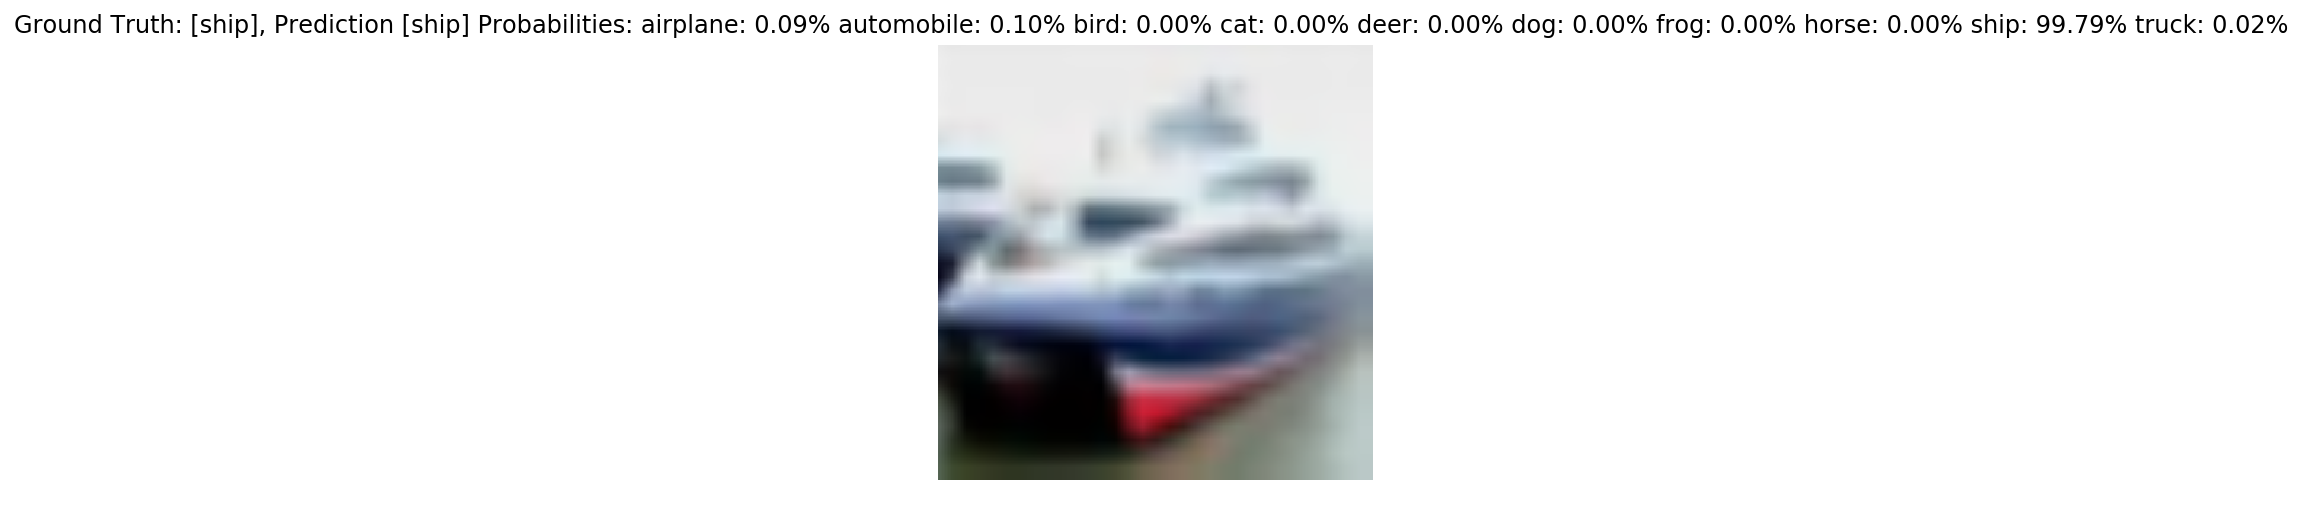

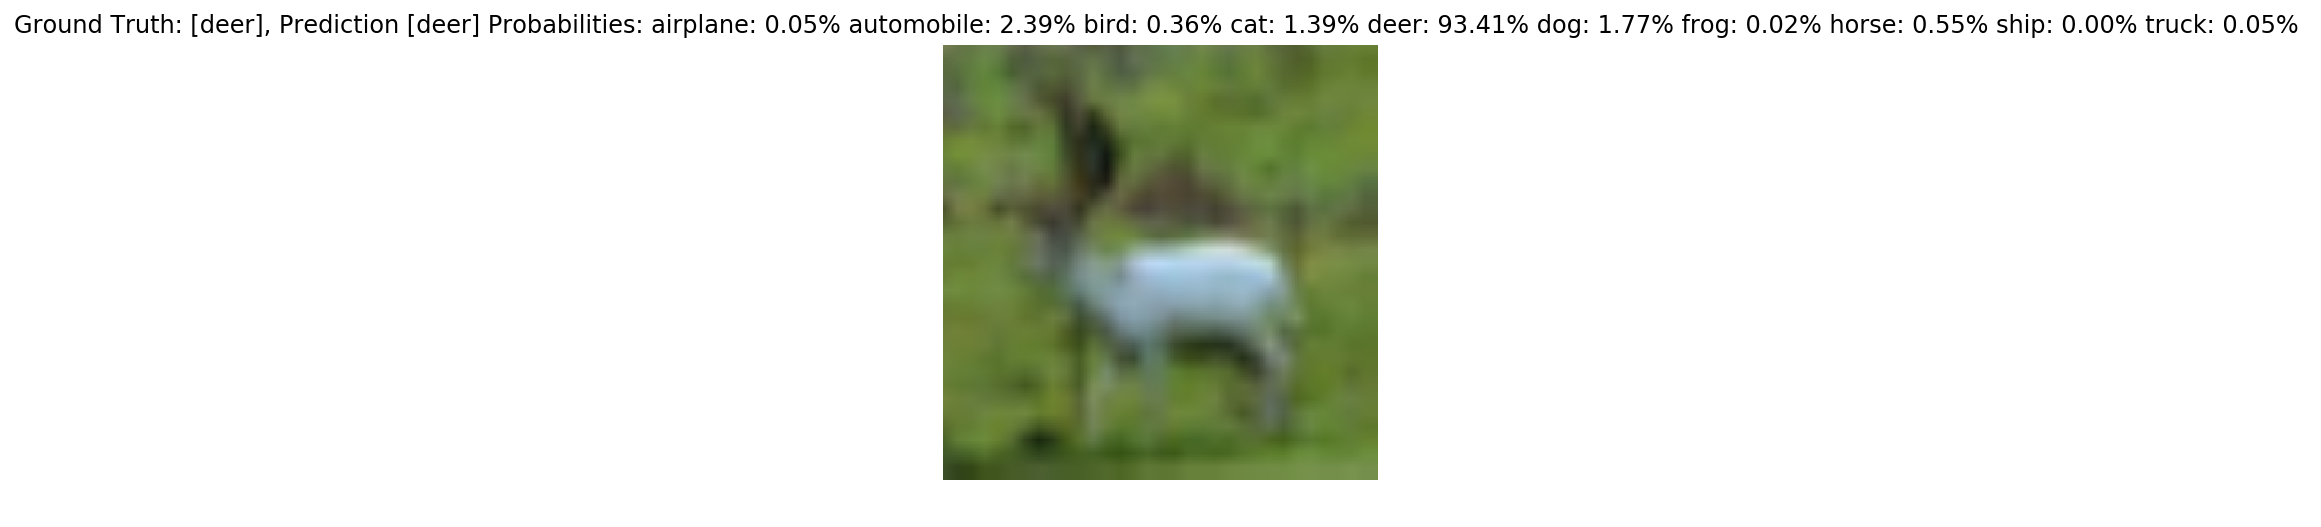

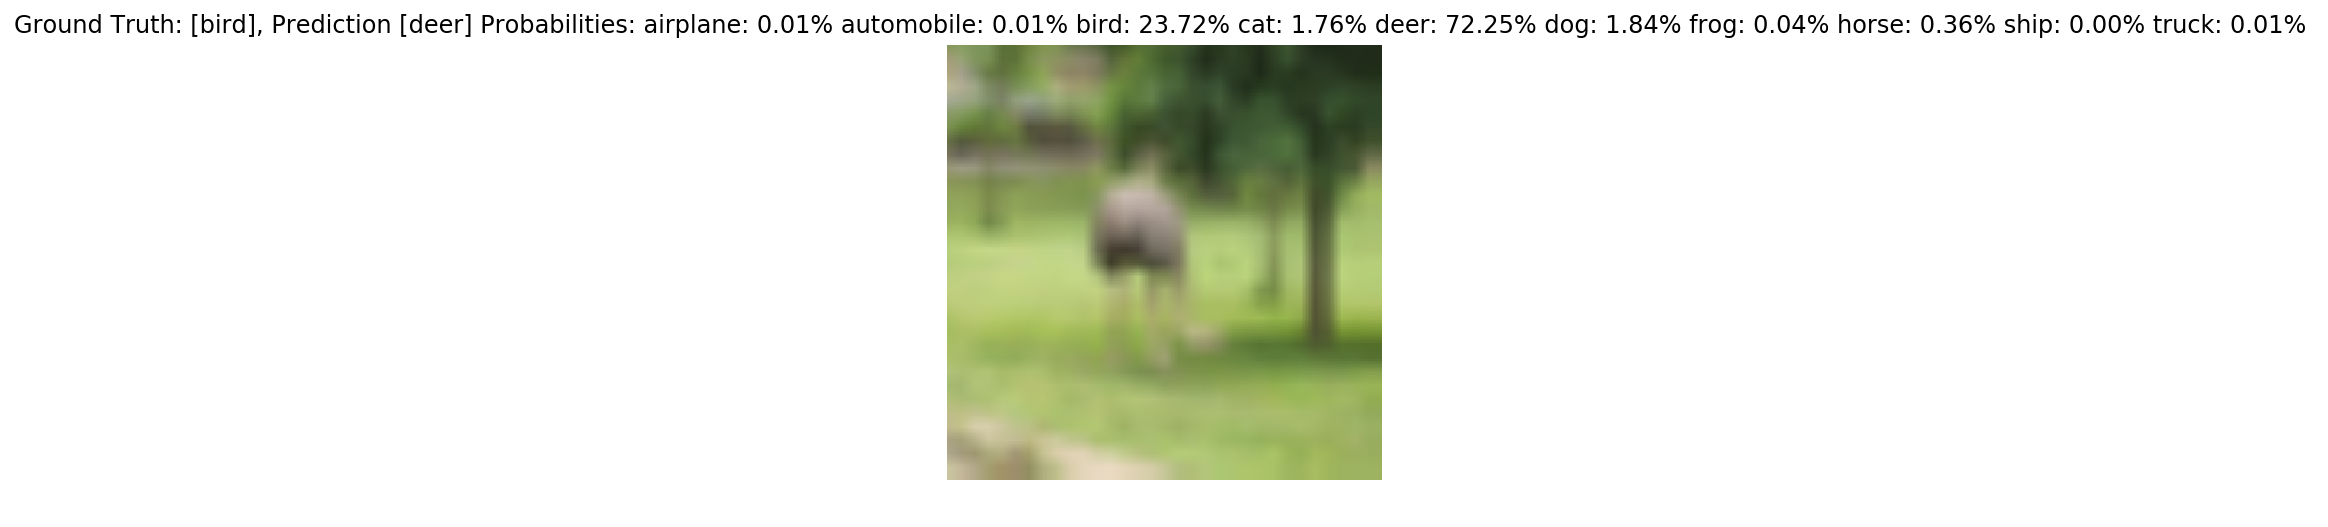

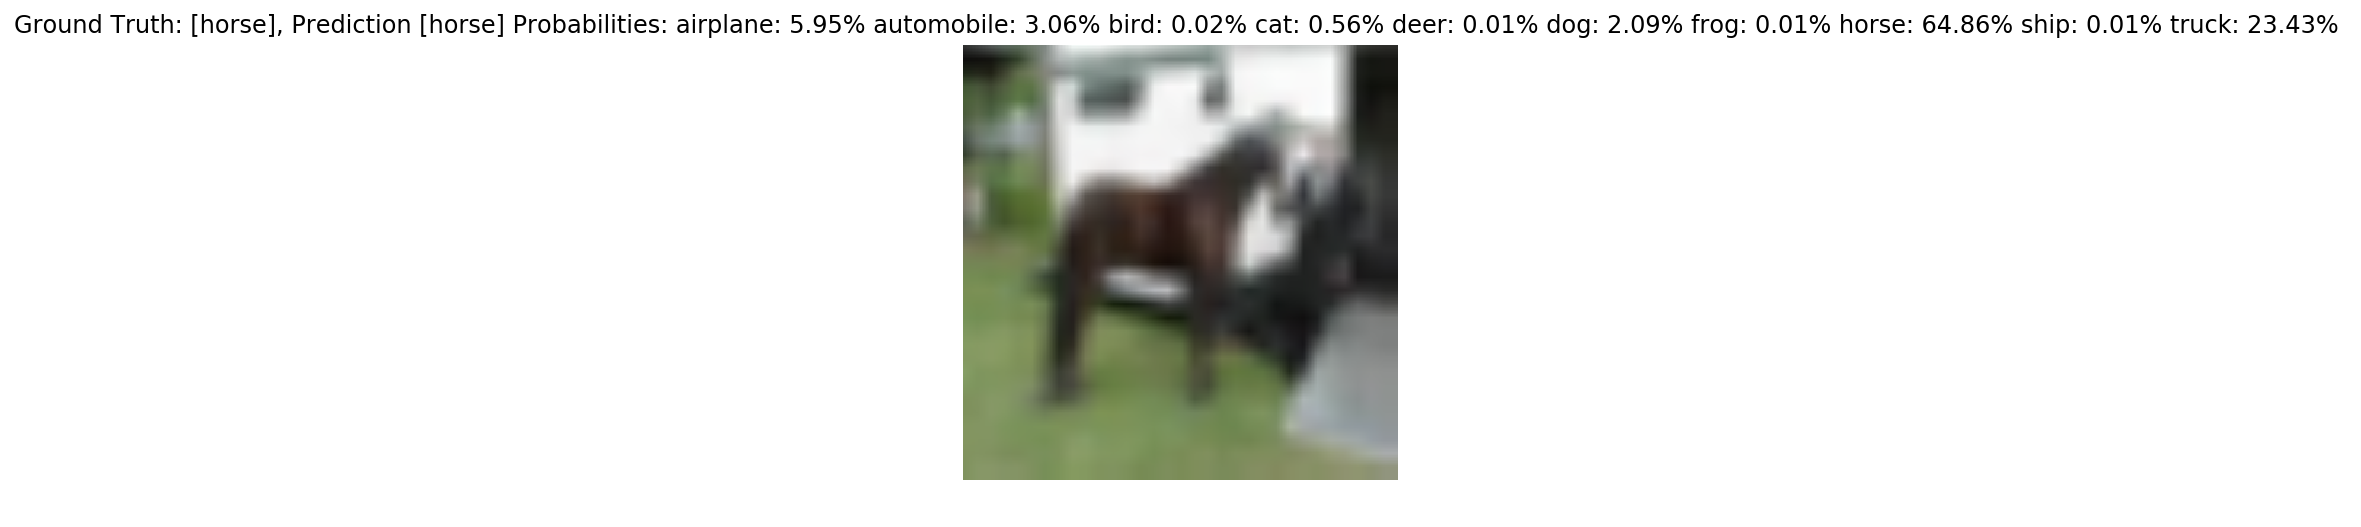

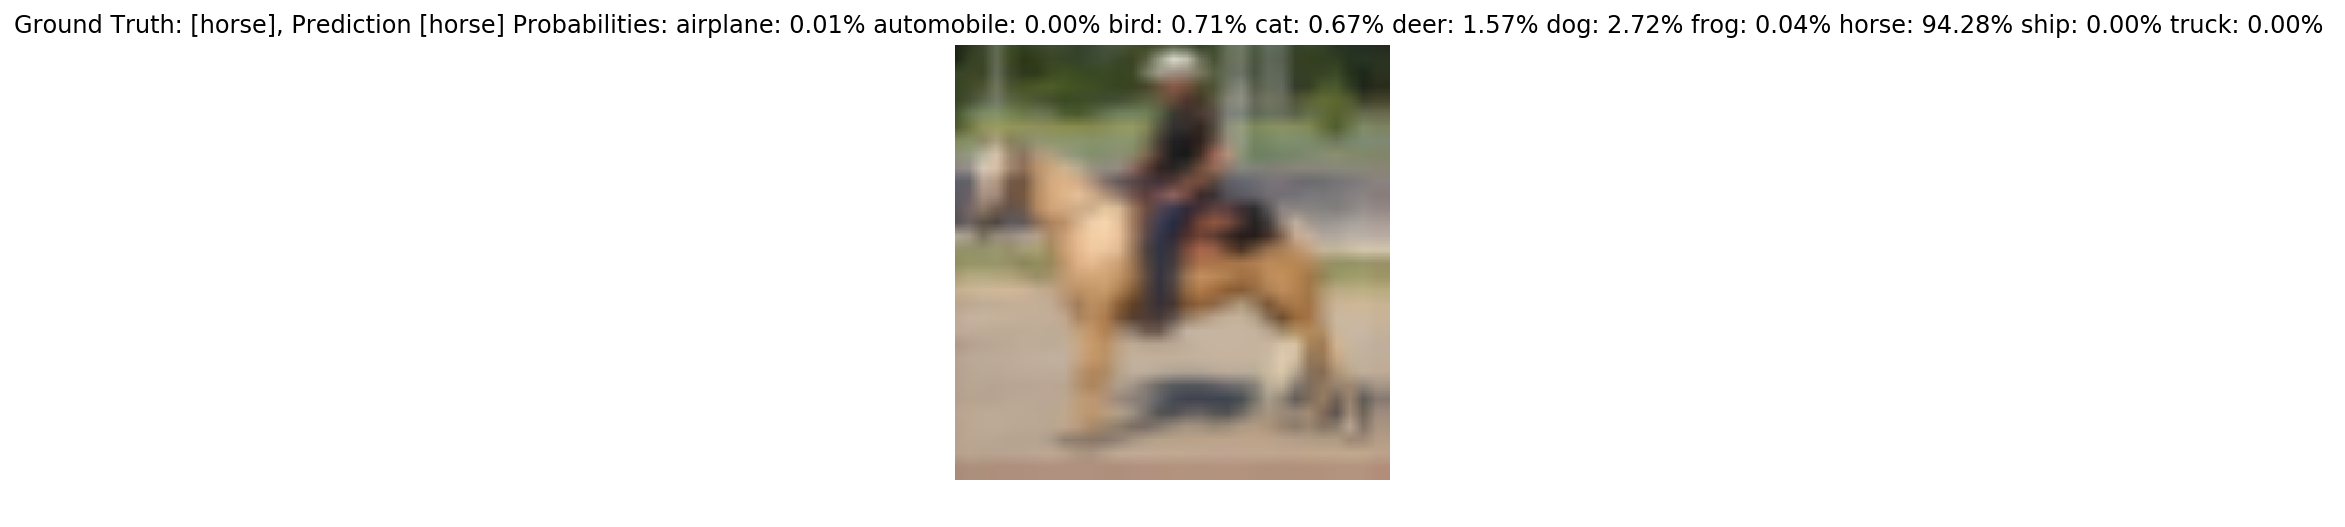

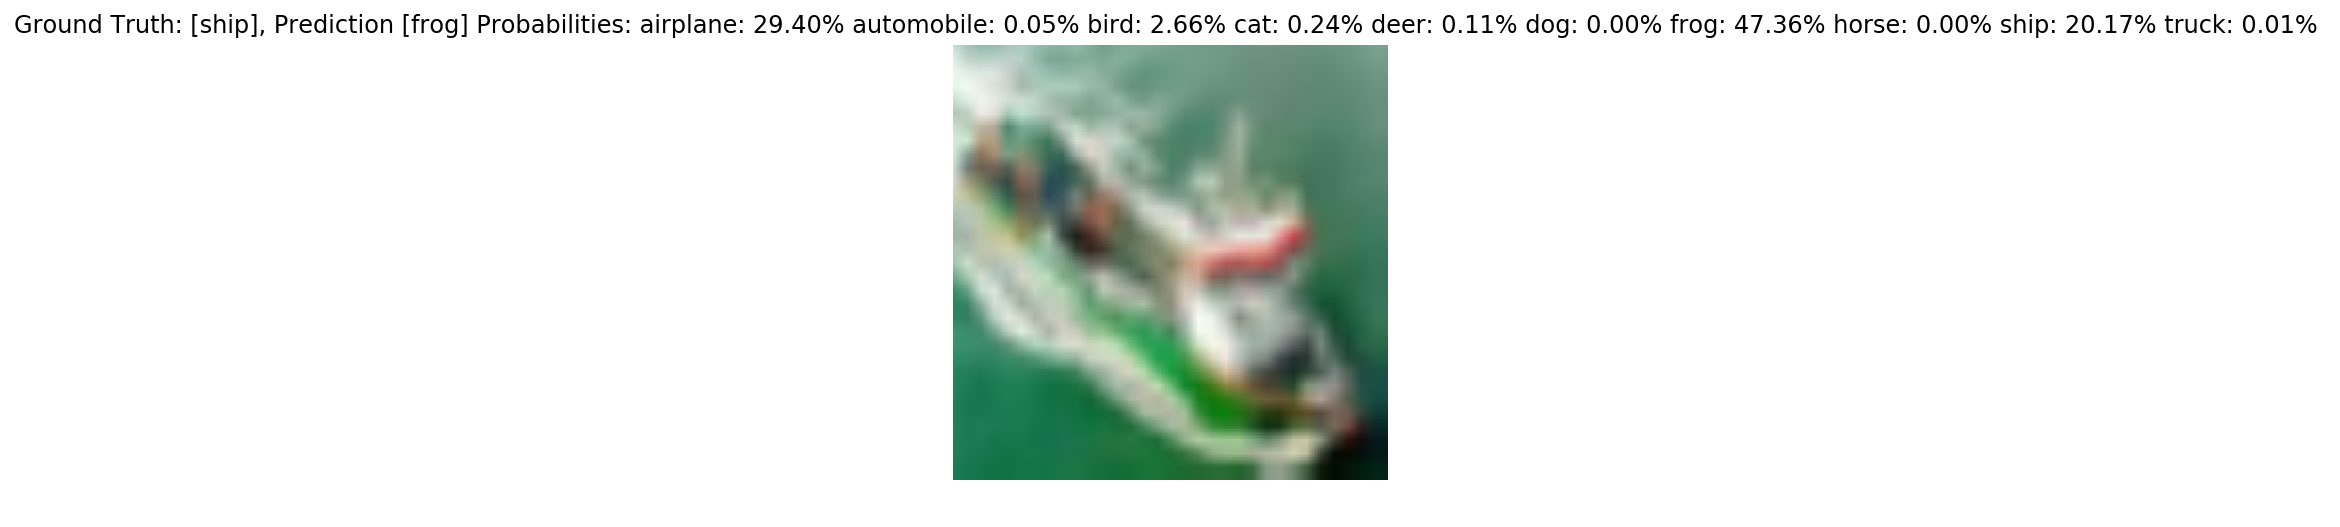

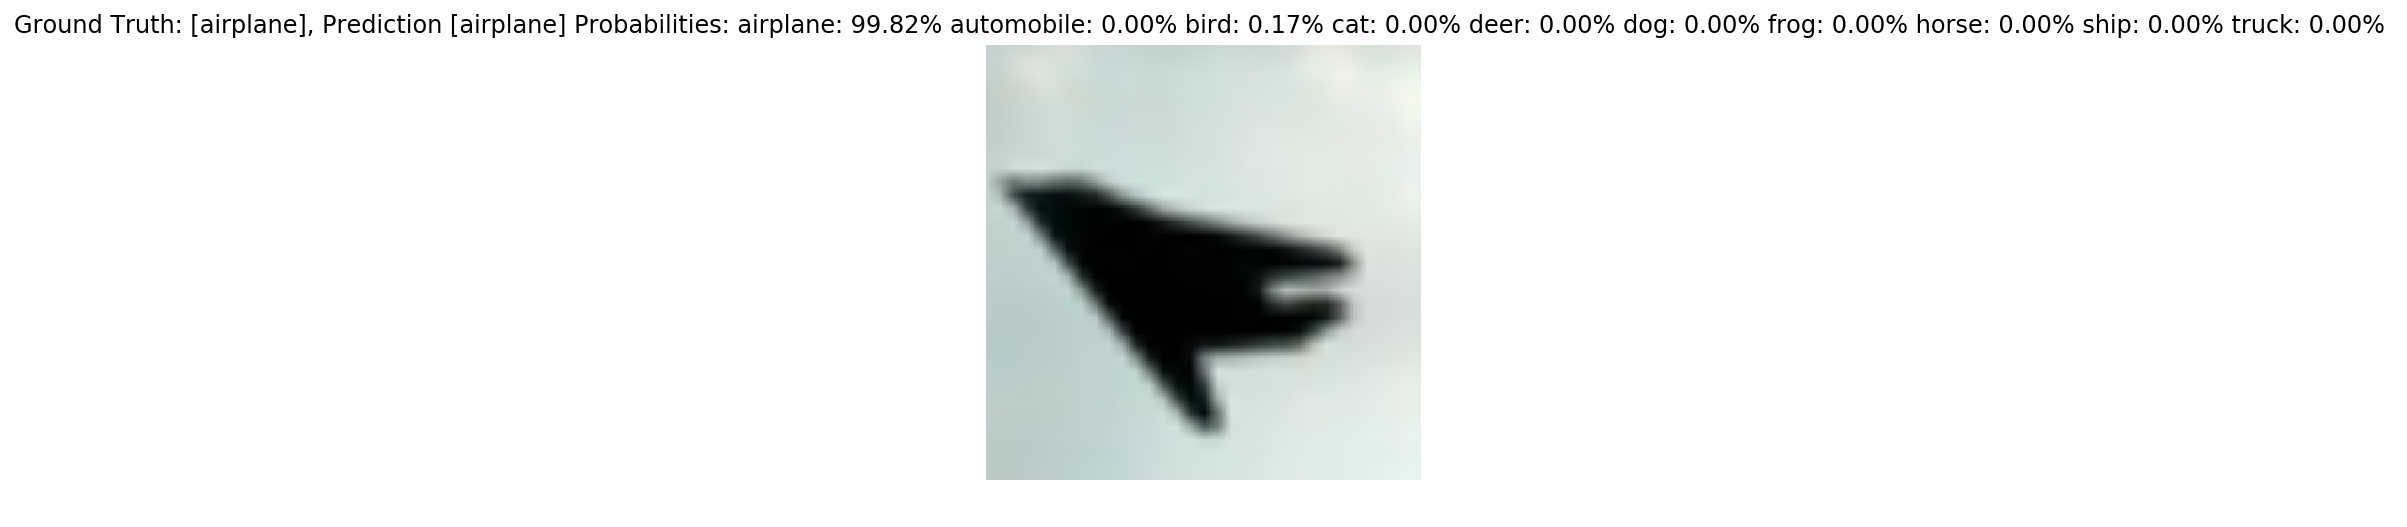

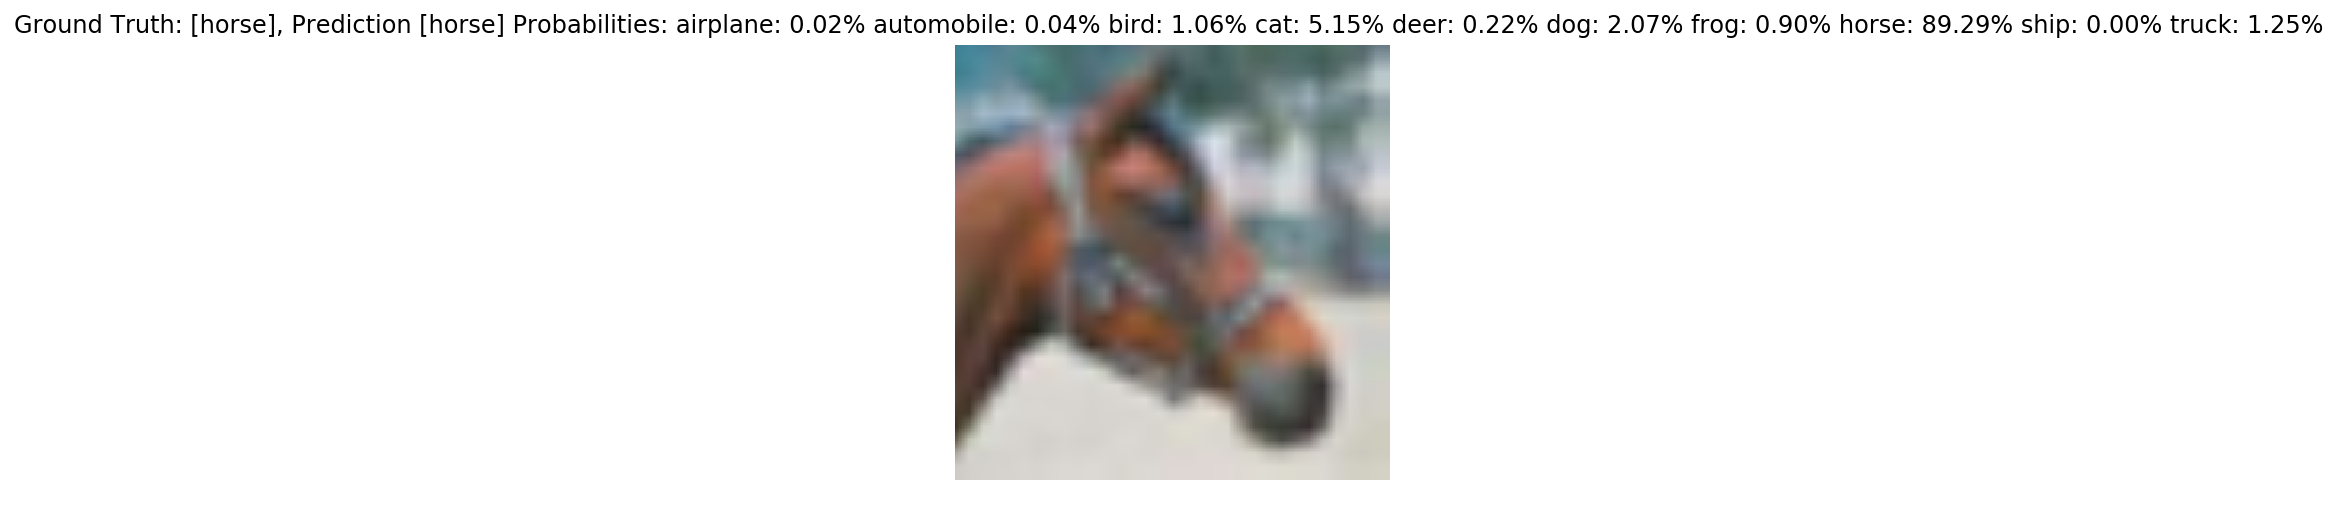

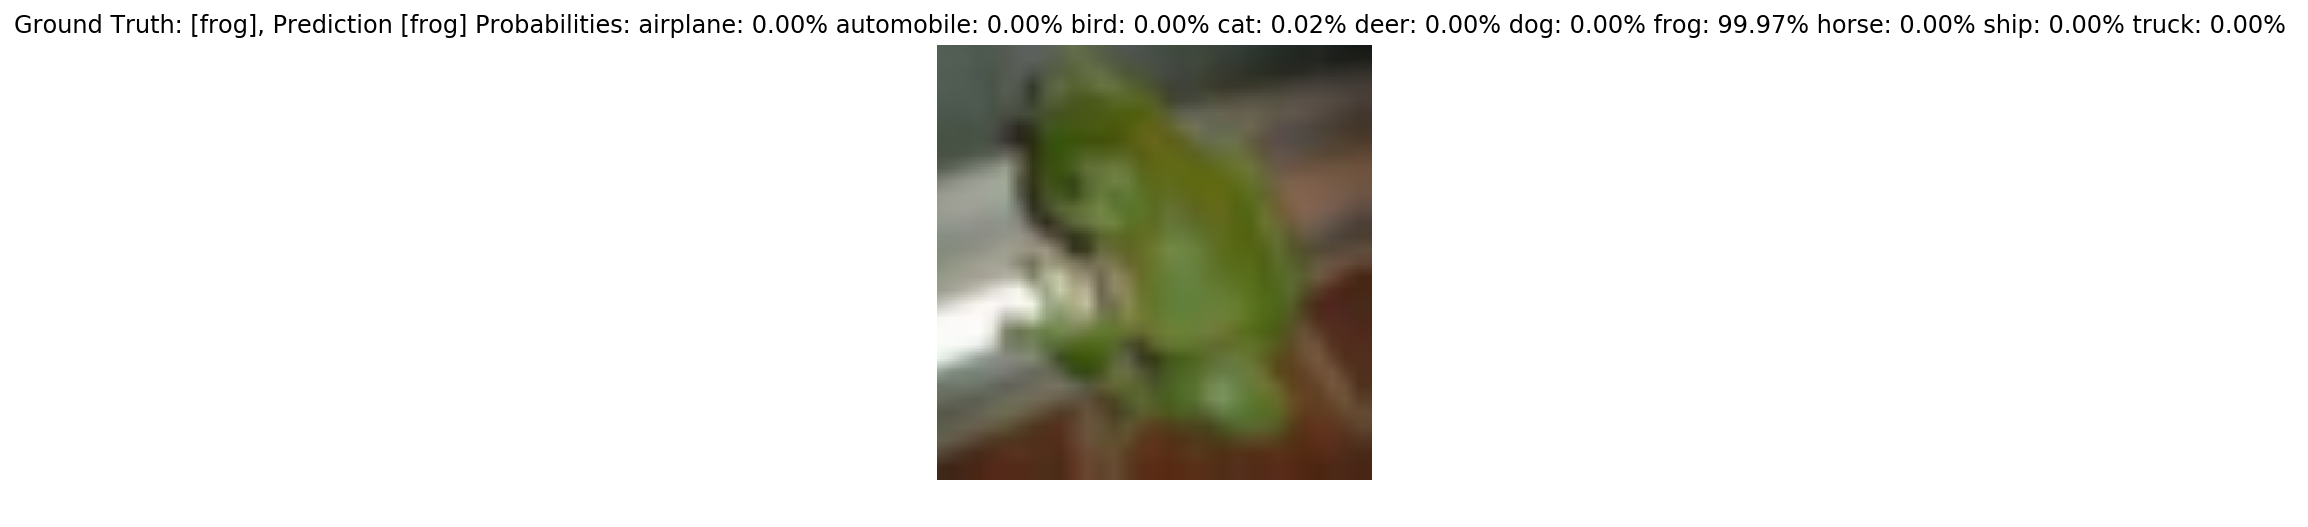

Overall accuracy 0.7985


In [36]:
BATCH_SIZE = 10
TEST_SAMPLE_SIZE = 10000

all_batch_stats = []

def getProbsAsStr(probabilities):
    probs_str = 'Probabilities: '
    for label, prob in zip(CLASS_NAMES, probabilities):
        probs_str += '%s: %.2f%% ' % (label, prob*100)
    return probs_str

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    test_dataset = get_dataset(
        os.path.join('tfrecord','cifar-10-test-tfrecord'), TEST_SAMPLE_SIZE)
    images, images_raw, labels = load_batch(
        test_dataset, BATCH_SIZE, INCEPTION_IMAGE_SIZE, INCEPTION_IMAGE_SIZE)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception_v3_arg_scope()):
        logits, _ = inception_v3(images, num_classes=test_dataset.num_classes, is_training=True)

    probabilities = tf.nn.softmax(logits)
    
    checkpoint_path = tf.train.latest_checkpoint(TRAINED_MODEL_DIR)
    init_fn = slim.assign_from_checkpoint_fn(checkpoint_path, slim.get_variables_to_restore())
    
    with tf.Session() as sess:
        with slim.queues.QueueRunners(sess):
            sess.run(tf.initialize_local_variables())
            init_fn(sess)
            all_accuracy = []
            for i in range(int(TEST_SAMPLE_SIZE/BATCH_SIZE)):
                np_probabilities, np_images_raw, np_labels = sess.run([probabilities, images_raw, labels])
                all_batch_stats.append((np_labels, np_probabilities))
                if i == 999: # show images 
                    for j in range(BATCH_SIZE): 
                        image = np_images_raw[j, :, :, :]
                        true_label = np_labels[j]
                        predicted_label = np.argmax(np_probabilities[j, :])
                        predicted_name = test_dataset.labels_to_names[predicted_label]
                        true_name = test_dataset.labels_to_names[true_label]
                        plt.figure()
                        plt.imshow(image.astype(np.uint8))
                        plt.title('Ground Truth: [%s], Prediction [%s] '
                                  % (true_name, predicted_name) + getProbsAsStr(np_probabilities[j, :]))
                        plt.axis('off')
                        plt.show()

# Calculate accuracy over the whole test set
all_batch_accuracy = []
for labels, probs in all_batch_stats:
    for label, prob in zip(labels, probs):
            all_batch_accuracy.append(np.argmax(prob) == label)
print('Overall accuracy', np.mean(all_batch_accuracy))

Indeed, the accuracy is much better. Evaluated over the whole test set of 10,000 images it is . Howerver, there is plenty of room for improvements. While our finetuned network will not be at the very bottom of the leaderboard ["state of the art in objects classification"](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html), the best model achieves 96.53%. At this point the neural network is better than a human that would achieve an accuracy of only 94%. This is simply amazing.